In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from utils.utils import convert_action

website to find .csv:

In [2]:
df = pd.read_csv('./data/IBM_test.csv')
# df['Date'] = pd.to_datetime(df.Date, format="%d/%m/%Y")
# df = df.sort_values('Date')
# df.to_csv('./data/AAPL.csv')
df[['Date','Open','High','Low','Close','Volume']].head()

,Date,Open,High,Low,Close,Volume
0,2015-12-31,139.070007,139.100006,137.570007,137.619995,3462100
1,2016-01-04,135.600006,135.970001,134.240005,135.949997,5229400
2,2016-01-05,136.759995,136.889999,134.850006,135.850006,3924800
3,2016-01-06,134.380005,135.580002,133.619995,135.169998,4310900
4,2016-01-07,133.699997,135.020004,132.429993,132.860001,7025800


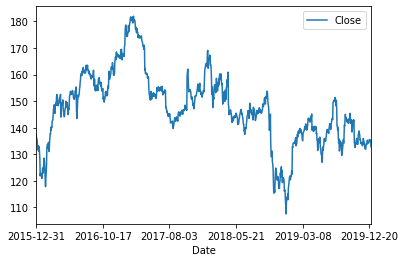

In [3]:
df.plot(x="Date", y="Close")

In [4]:
df.head()

,Unnamed: 0,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,4024,2015-12-31,139.070007,139.100006,137.570007,137.619995,114.207855,3462100
1,1,4025,2016-01-04,135.600006,135.970001,134.240005,135.949997,112.821960,5229400
2,2,4026,2016-01-05,136.759995,136.889999,134.850006,135.850006,112.738976,3924800
3,3,4027,2016-01-06,134.380005,135.580002,133.619995,135.169998,112.174667,4310900
4,4,4028,2016-01-07,133.699997,135.020004,132.429993,132.860001,110.257637,7025800


## Let the DQN trade

In [5]:
from networks.DQN import MyModel
from env.StockTradingEnv import StockTradingEnv
import tensorflow as tf

from tensorflow.keras.models import load_model

### Parameters of the DQN model (taken from main_with_dqn)

In [6]:
env = StockTradingEnv(df)

num_actions = 2
hidden_units = [64,128,256,256,128,64]
input_shape = env.observation_space.sample().shape
in_log = True ### for the environment to use logs and no divisions by max value

path_weights_a = "save_models/DQN_best" # last number is number of episodes trained
path_weights_b = "save_models/DQN_400"
path_weights_c = "save_models/DQN_1000"

### Build the Agent

In [7]:
class TradingAgent():
    """A class to simplify the trading decisions"""
    def __init__(self, model, path_weights, name):
        self.model = model
        self.model.load_weights(path_weights)
        self.name = name # name of the agent
    
    def get_action(self, state): #meant for only a single state for input
        prediction = self.model.predict(state)
        return np.argmax(prediction[0])

In [8]:
trade_model_a = MyModel(input_shape, hidden_units, num_actions)
trade_model_b = MyModel(input_shape, hidden_units, num_actions)
trade_model_c = MyModel(input_shape, hidden_units, num_actions)

# trade_model.load_weights(path_weights)
Agent_a = TradingAgent(trade_model_a, path_weights_a, "agent_a")
Agent_b = TradingAgent(trade_model_b, path_weights_b, "agent_b")
Agent_c = TradingAgent(trade_model_c, path_weights_c, "agent_c")

agents = [Agent_a]

### Run over the data frame

In [9]:
int(False)

0

In [10]:
df_results = pd.DataFrame(columns=['Date','Index', 'agent_a', 'agent_b', 'agent_c','agent_a_pred','y_true'], index=df.index)
df_results['Date'] = df['Date']

with open("./data/actions.txt", "rb") as fp:   # Unpickling
    actions = pickle.load(fp)

# Compute the Index value
for i in range(len(df.loc[:, 'Open'].values) - 6):
    df_results.loc[i+5, "Index"] = df.loc[i+5, "Close"] * env.initial_account_balance / df.loc[5, "Close"] # i + 5 because of the format of the data
    
    if i+6 <= len(df.loc[:, 'Open'].values)-1:
        goes_down = (df.loc[i+6, "Close"] - df.loc[i+5, "Close"] <= 0)
        df_results.loc[i+5, "y_true"] = int(goes_down) #1 if market went down, 0 if market went up


# Compute the Agents' net_worth
for Agent in agents:
    env = StockTradingEnv(df)
    input_shape = env.observation_space.sample().shape
    observation = env.reset_to_day_one().reshape(1,input_shape[0],input_shape[1]).astype('float32') # necessary to reshape each observation
    
    
    for i in range(len(df.loc[:, 'Open'].values) - 6):
        action = Agent.get_action(observation.reshape(1,input_shape[0],input_shape[1]).astype('float32'))
        action = convert_action(action, binary_action=True)
        df_results.loc[i+5, "{}_pred".format(Agent.name)] = int(action[0]) #0 if buy, 1 if sell
        df_results.loc[i+5, Agent.name] = env.net_worth
        observation, reward, done, _ = env.step(action)

        df_results.loc[i+5, Agent.name] = env.net_worth

        print("\r {}, day {} out of {}".format(Agent.name, i, len(df.loc[:, 'Open'].values) - 7), end = "")
    print("")
    
    print("last net_worth: {}".format(env.net_worth))
    
    env.close()

 agent_a, day 999 out of 999
last net_worth: 10965.23043700001


### Visualize the results

#### On training set

#### On validation set

In [11]:
from matplotlib.pyplot import subplots

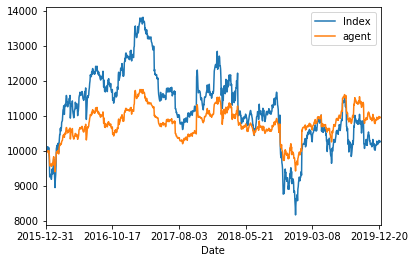

In [12]:
fig, ax = subplots()
df_results.plot(x="Date", y=["Index", "agent_a"], ax=ax)
ax.legend(["Index","agent"])
# fig.savefig("imgs/DQN_mlp.png")

### About the statistics

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [14]:
y_true = df_results["y_true"][5:-1].astype("int32")
y_pred = df_results["agent_a_pred"][5:-1].astype("int32")

In [15]:
accuracy_score(y_true, y_pred)

0.507

In [16]:
confusion_matrix(y_true, y_pred)

array([[302, 226],
       [267, 205]], dtype=int64)

In [17]:
diff = df_results["agent_a"][5:-1] - df_results["Index"][5:-1]
score = diff.mean()
score

-419.4573570355138